In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display

def mc_asian_option(S0, K, r, sigma, T, M=100, N=10000, option="call"):
    """
    Monte Carlo pricing of an Asian option (arithmetic average).
    S0: initial stock price
    K: strike price
    r: risk-free rate
    sigma: volatility
    T: time to maturity (in years)
    M: number of timesteps
    N: number of simulations
    option: "call" or "put"
    """
    dt = T / M
    # simulate price paths
    Z = np.random.randn(N, M)
    ST_paths = np.zeros((N, M+1))
    ST_paths[:,0] = S0
    for t in range(1, M+1):
        ST_paths[:,t] = ST_paths[:,t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[:,t-1])
    
    # arithmetic average
    S_avg = ST_paths[:,1:].mean(axis=1)
    if option == "call":
        payoff = np.maximum(S_avg - K, 0)
    else:
        payoff = np.maximum(K - S_avg, 0)
    return np.exp(-r*T) * payoff.mean()


def mc_barrier_option(S0, K, r, sigma, T, B, M=100, N=10000, option="call", barrier_type="up-and-out"):
    """
    Monte Carlo pricing of a barrier option.
    barrier_type: "up-and-out", "down-and-out"
    """
    dt = T / M
    Z = np.random.randn(N, M)
    ST_paths = np.zeros((N, M+1))
    ST_paths[:,0] = S0
    for t in range(1, M+1):
        ST_paths[:,t] = ST_paths[:,t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[:,t-1])
    
    if option == "call":
        payoff = np.maximum(ST_paths[:,-1] - K, 0)
    else:
        payoff = np.maximum(K - ST_paths[:,-1], 0)

    # Apply barrier condition
    if "up" in barrier_type:
        knocked = (ST_paths.max(axis=1) >= B)
    else:  # down barrier
        knocked = (ST_paths.min(axis=1) <= B)

    if "out" in barrier_type:
        payoff[knocked] = 0
    else:  # "in"
        payoff[~knocked] = 0

    return np.exp(-r*T) * payoff.mean()
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0

asian_call = mc_asian_option(S0, K, r, sigma, T)
barrier_call = mc_barrier_option(S0, K, r, sigma, T, B=120, barrier_type="up-and-out")

print(f"Asian Call Price (MC): {asian_call:.4f}")
print(f"Barrier Call Price (MC): {barrier_call:.4f}")


Asian Call Price (MC): 5.8376
Barrier Call Price (MC): 1.4688


In [4]:
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src"))
from implied_vol import implied_volatility
from bs import black_scholes_price 
from binomial import crr_price
from implied_vol import implied_volatility
from bs import black_scholes_price

# Dropdown for stocks
stock_list = ["AAPL", "NFLX", "PLTR", "NVDA", "META", "AMZN"]
dropdown = widgets.Dropdown(options=stock_list, description="Stock:", value="AAPL")
display(dropdown)

# Pick selected ticker
ticker_symbol = dropdown.value
ticker = yf.Ticker(ticker_symbol)

# Current stock price
S0 = ticker.history(period="1d")["Close"].iloc[-1]
print(f"Selected: {ticker_symbol} | Current Price: {S0:.2f}")

# Pick nearest expiry if available
if ticker.options:
    expiries = ticker.options
    expiry = expiries[0]
    opt_chain = ticker.option_chain(expiry)
    calls = opt_chain.calls
    atm_row = calls.iloc[(calls['strike'] - S0).abs().argsort()[:1]]
    K = atm_row['strike'].values[0]
    market_price = atm_row['lastPrice'].values[0]

    # Time to expiry
    today = datetime.date.today()
    expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d").date()
    T = (expiry_date - today).days / 365

    r = 0.05  # assume risk-free

    # --- Implied volatility from market price
    sigma = implied_volatility(S0, K, T, r, market_price, option_type="call")
    print(f"Expiry: {expiry}, Strike: {K}, Market Price: {market_price}")
    print(f"Implied Volatility (ATM): {sigma:.4f}")
else:
    print(f"{ticker_symbol} has no listed options.")
    K, T, r, sigma = None, None, 0.05, 0.2  # defaults for testing


Dropdown(description='Stock:', options=('AAPL', 'NFLX', 'PLTR', 'NVDA', 'META', 'AMZN'), value='AAPL')

Selected: AAPL | Current Price: 237.44
Expiry: 2025-09-05, Strike: 237.5, Market Price: 1.36
Implied Volatility (ATM): 0.2774


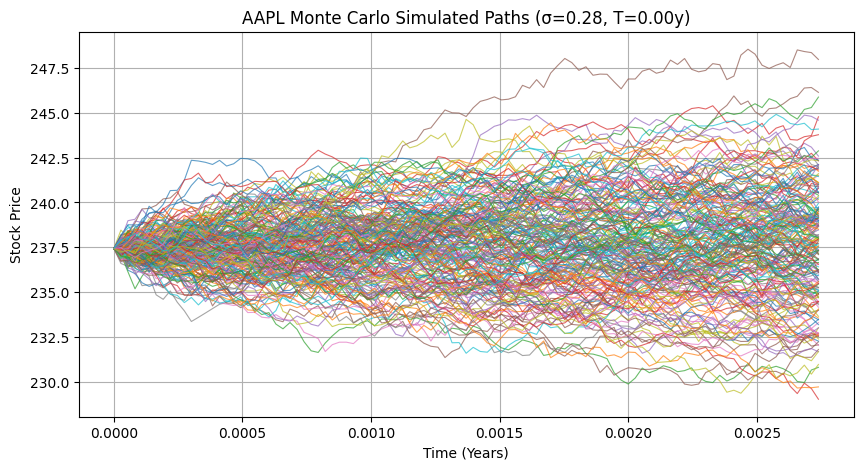

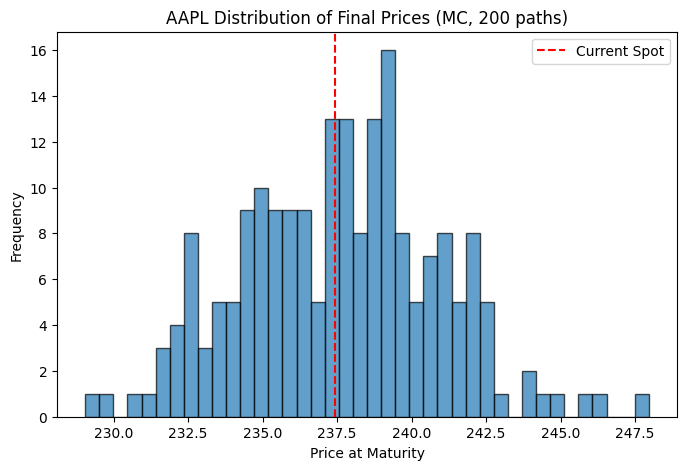

Asian Call Price (MC): 0.7744
Barrier Call Price (MC): 1.3683
(Market Price of ATM Call: 1.3600)


In [5]:
# --- Parameters from Cell 4 ---
M = 100        # steps
N_paths = 200  # sample paths for plotting
N_mc = 50000   # simulations for pricing
dt = T / M

# --- Simulate price paths
Z = np.random.randn(N_paths, M)
ST_paths = np.zeros((N_paths, M+1))
ST_paths[:,0] = S0

for t in range(1, M+1):
    ST_paths[:,t] = ST_paths[:,t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[:,t-1])

# --- Plot simulated sample paths
plt.figure(figsize=(10,5))
for i in range(N_paths):
    plt.plot(np.linspace(0, T, M+1), ST_paths[i], lw=0.8, alpha=0.7)
plt.title(f"{ticker_symbol} Monte Carlo Simulated Paths (σ={sigma:.2f}, T={T:.2f}y)")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

# --- Histogram of final prices
plt.figure(figsize=(8,5))
plt.hist(ST_paths[:,-1], bins=40, alpha=0.7, edgecolor="black")
plt.axvline(S0, color="red", linestyle="--", label="Current Spot")
plt.title(f"{ticker_symbol} Distribution of Final Prices (MC, {N_paths} paths)")
plt.xlabel("Price at Maturity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- Asian & Barrier option prices (MC, with real IV)
asian_call = mc_asian_option(S0, K, r, sigma, T, M=100, N=N_mc)
barrier_call = mc_barrier_option(S0, K, r, sigma, T, B=1.2*S0, M=100, N=N_mc, barrier_type="up-and-out")

print(f"Asian Call Price (MC): {asian_call:.4f}")
print(f"Barrier Call Price (MC): {barrier_call:.4f}")
print(f"(Market Price of ATM Call: {market_price:.4f})")
